# Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1

- Data: https://nsidc.org/data/NSIDC-0321/versions/1 (downloaded 14/10/2020)

## Abstract
This data set comprises global, 8-day Snow-Covered Area (SCA) and Snow Water Equivalent (SWE) data from 2000 through 2008. Global SWE data are derived from the Special Sensor Microwave Imager (SSM/I) and are enhanced with MODIS/Terra Snow Cover 8-Day Level 3 Global 0.05 degree Climate Modeling Grid (CMG) data. Global data are gridded to the Northern and Southern 25 km Equal-Area Scalable Earth Grids (EASE-Grids). These data are suitable for continental-scale time-series studies of snow cover and snow water equivalent. The data are in netCDF data files and PNG browse image files available via FTP.

## Data access on CICLAD
Path on CICLAD: `/data/mlalande/NSIDC/nsidc0321_blended_ssmi_modis/`


## Python environment
conda env: new `phd_v3` (in `envs/phd`)

# Import modules

In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [3]:
xr.__version__

'0.16.0'

# Define paths

In [4]:
# path = '/data/mlalande/NSIDC/nsidc0321_blended_ssmi_modis/'
path = '/home/lalandmi/data/nsidc0321_blended_ssmi_modis/'

# Get data

In [5]:
ds = xr.open_mfdataset(path+'/north/NL.*.nsidc0321v01.nc', combine='by_coords')

In [6]:
# ds

In [7]:
scf_with_mask = ds.SCA
swe_with_mask = ds.SWE

In [61]:
# scf_with_mask
# swe_with_mask

### SCF
 0          : no snow  
 1 to 100   : percent MODIS snow-covered area  
 -175       : no SCA, due to to cloud/fill/night  
 -200       : fixed value for corners  
 -250       : ocean  
 -300       : permanent ice sheets and large glaciers

### SWE
 \> 0       : SWE from deep microwave algorithm for 8-day period  
 0          : no snow  
 -100 to -1 : -1 * SWE from shallow microwave algorithm  
 -150       : missing microwave brightness temperatures  
 -200       : fixed value for corners  
 -250       : ocean  
 -300       : permanent ice sheets and large glaciers  
 -350       : no microwave SWE, but visible SCA > 25%

In [8]:
scf = scf_with_mask.where( (scf_with_mask >= 0) & (scf_with_mask <= 100) )

swe = swe_with_mask.where(swe_with_mask >= 0)
swe_from_mw_algo = -1 * swe_with_mask.where( (swe_with_mask >= -100) & (swe_with_mask <= -1) )

## Get std of topography at 25 km
http://www.temis.nl/data/gmted2010/

In [21]:
gmted = xr.open_dataset('/home/lalandmi/data/GMTED2010/GMTED2010_15n060_0250deg.nc')

In [37]:
std = gmted \
    .assign_coords({'nlat': gmted.latitude, 'nlon': gmted.longitude}) \
    .rename({'nlat': 'lat', 'nlon': 'lon'}) \
    .elevation_stddev

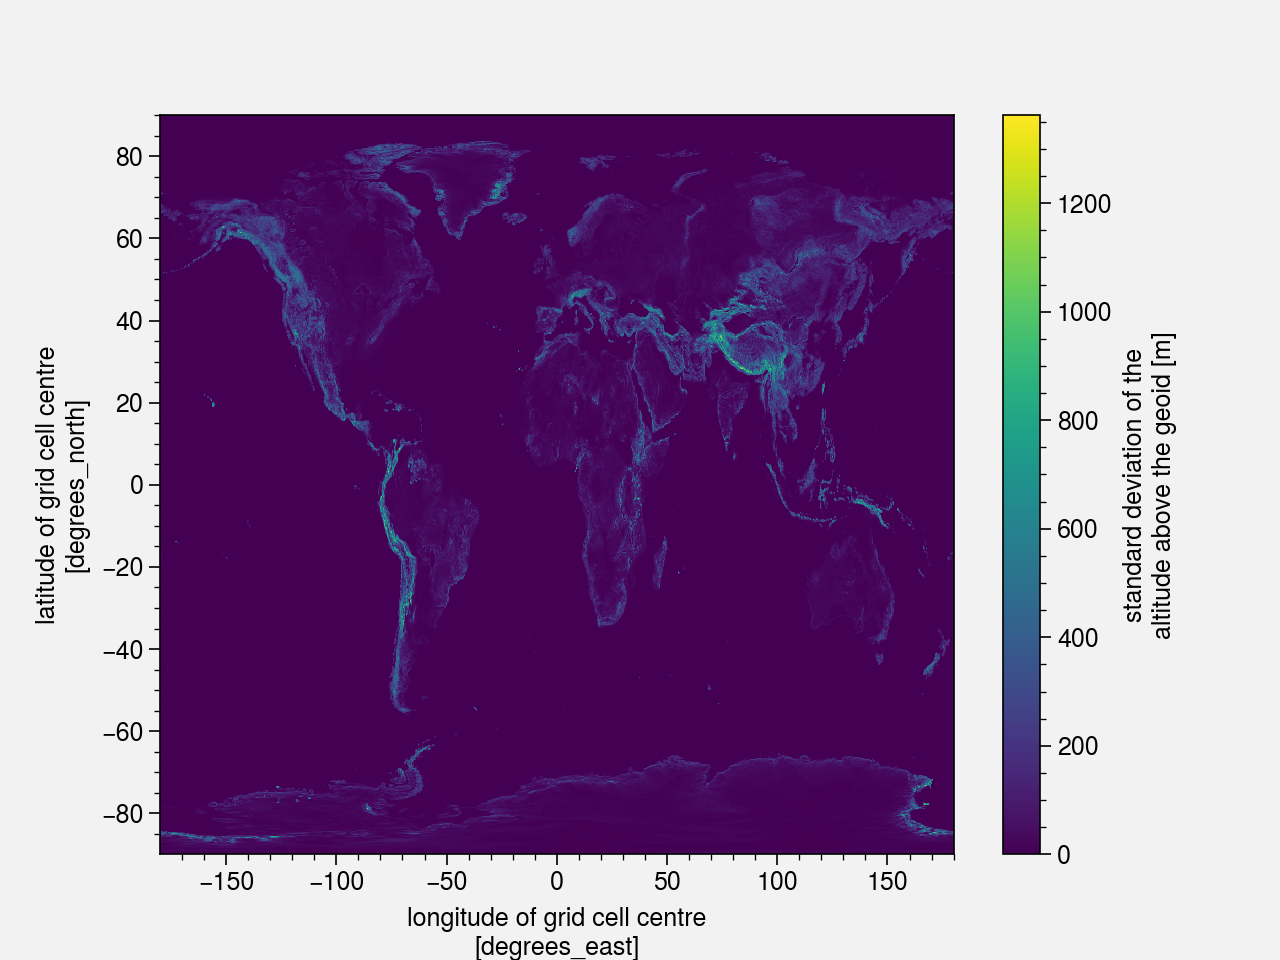

In [40]:
std.plot()

## Regrid on topo

In [44]:
scf_regrid = u.regrid(scf.rename({'longitude': 'lon', 'latitude': 'lat'}), std, 
                      globe=False, periodic=False)

Create weight file: bilinear_721x721_720x1440.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [45]:
swe_regrid = u.regrid(swe.rename({'longitude': 'lon', 'latitude': 'lat'}), std, 
                      globe=False, periodic=False)

Reuse existing file: bilinear_721x721_720x1440.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [46]:
# Select domain and period
zone = 'HMA'
latlim, lonlim = u.get_zone(zone)

scf_regrid_HMA = scf_regrid.sel(lat=latlim, lon=lonlim)
swe_regrid_HMA = swe_regrid.sel(lat=latlim, lon=lonlim)
std_HMA = std.sel(lat=latlim, lon=lonlim)

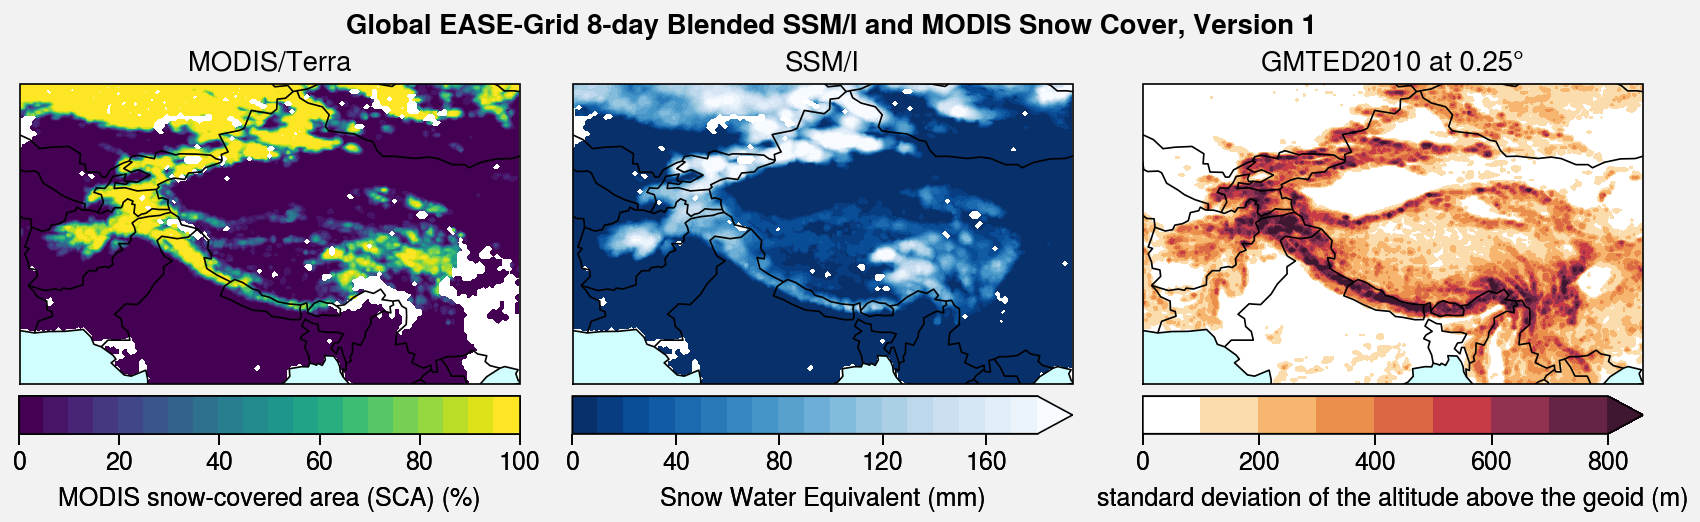

In [75]:
fig, axs = plot.subplots(proj='cyl', ncols=3)

cmap_scf='viridis'
levels_scf=plot.arange(0,100,5)
extend_scf='neither'

cmap_swe='Blues_r'
levels_swe=plot.arange(0,180,10)
extend_swe='max'

cmap_std='Fire'
levels_std=plot.arange(0,800,100)
extend_std='max'


# SCF
axs[0].contourf(scf_regrid_HMA[0], colorbar='b',
                cmap=cmap_scf, levels=levels_scf, extend=extend_scf)
axs[0].format(title='MODIS/Terra')

# SWE
axs[1].contourf(swe_regrid_HMA[0], colorbar='b',
                cmap=cmap_swe, levels=levels_swe, extend=extend_swe)
axs[1].format(title='SSM/I')

# STD
axs[2].contourf(std_HMA, colorbar='b',
                cmap=cmap_std, levels=levels_std, extend=extend_std)
axs[2].format(title='GMTED2010 at 0.25°')


axs.format(
    labels=False, grid=False, coast=True, borders=True,
    ocean=True, oceancolor='pale blue',
    suptitle='Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1',
    lonlim=(lonlim.start, lonlim.stop),
    latlim=(latlim.start, latlim.stop)
)

## SCF/SWE plots

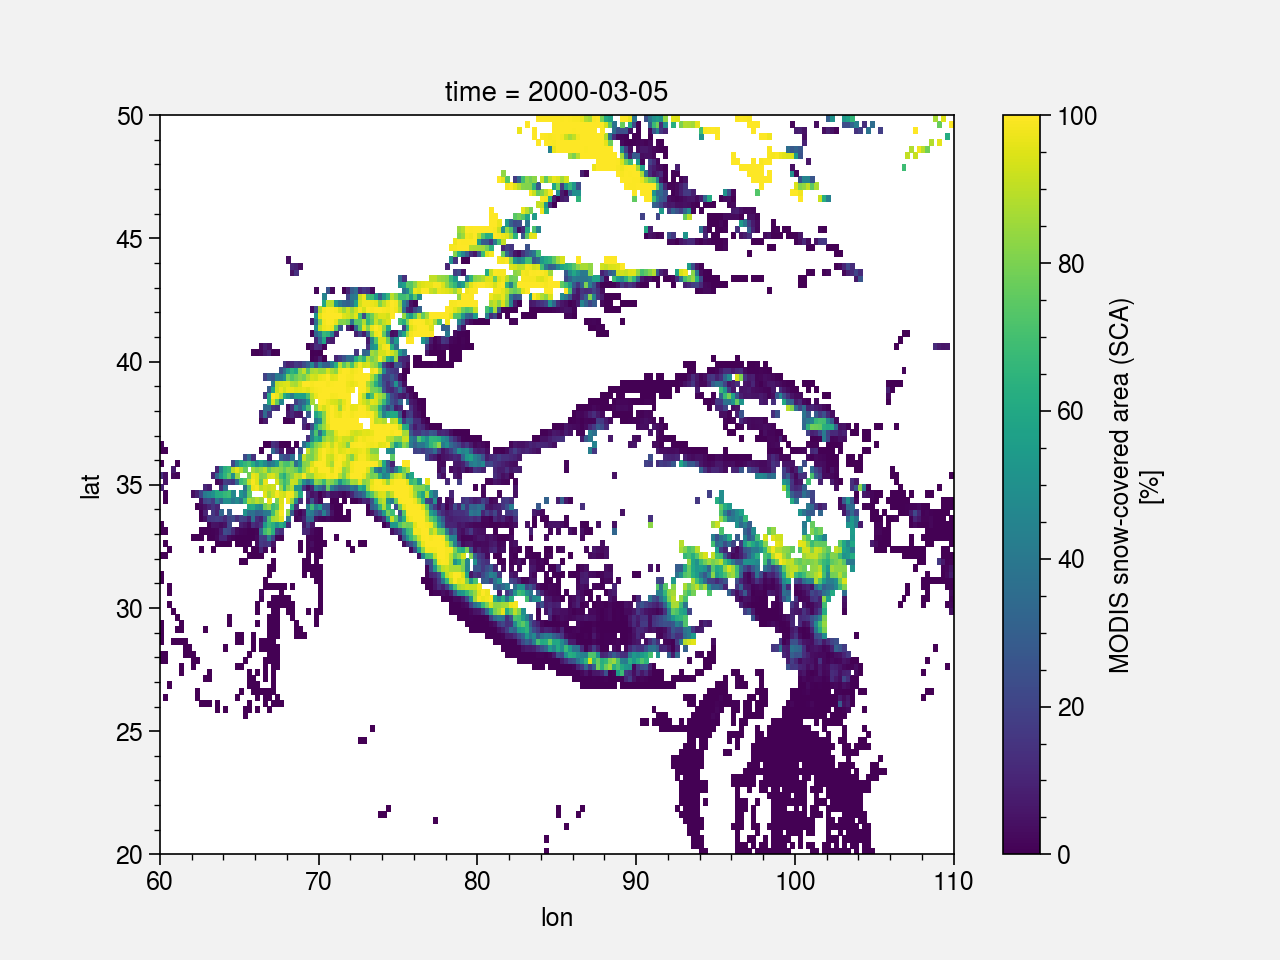

In [135]:
scf_regrid_HMA.where(std_HMA > 200)[0].plot()

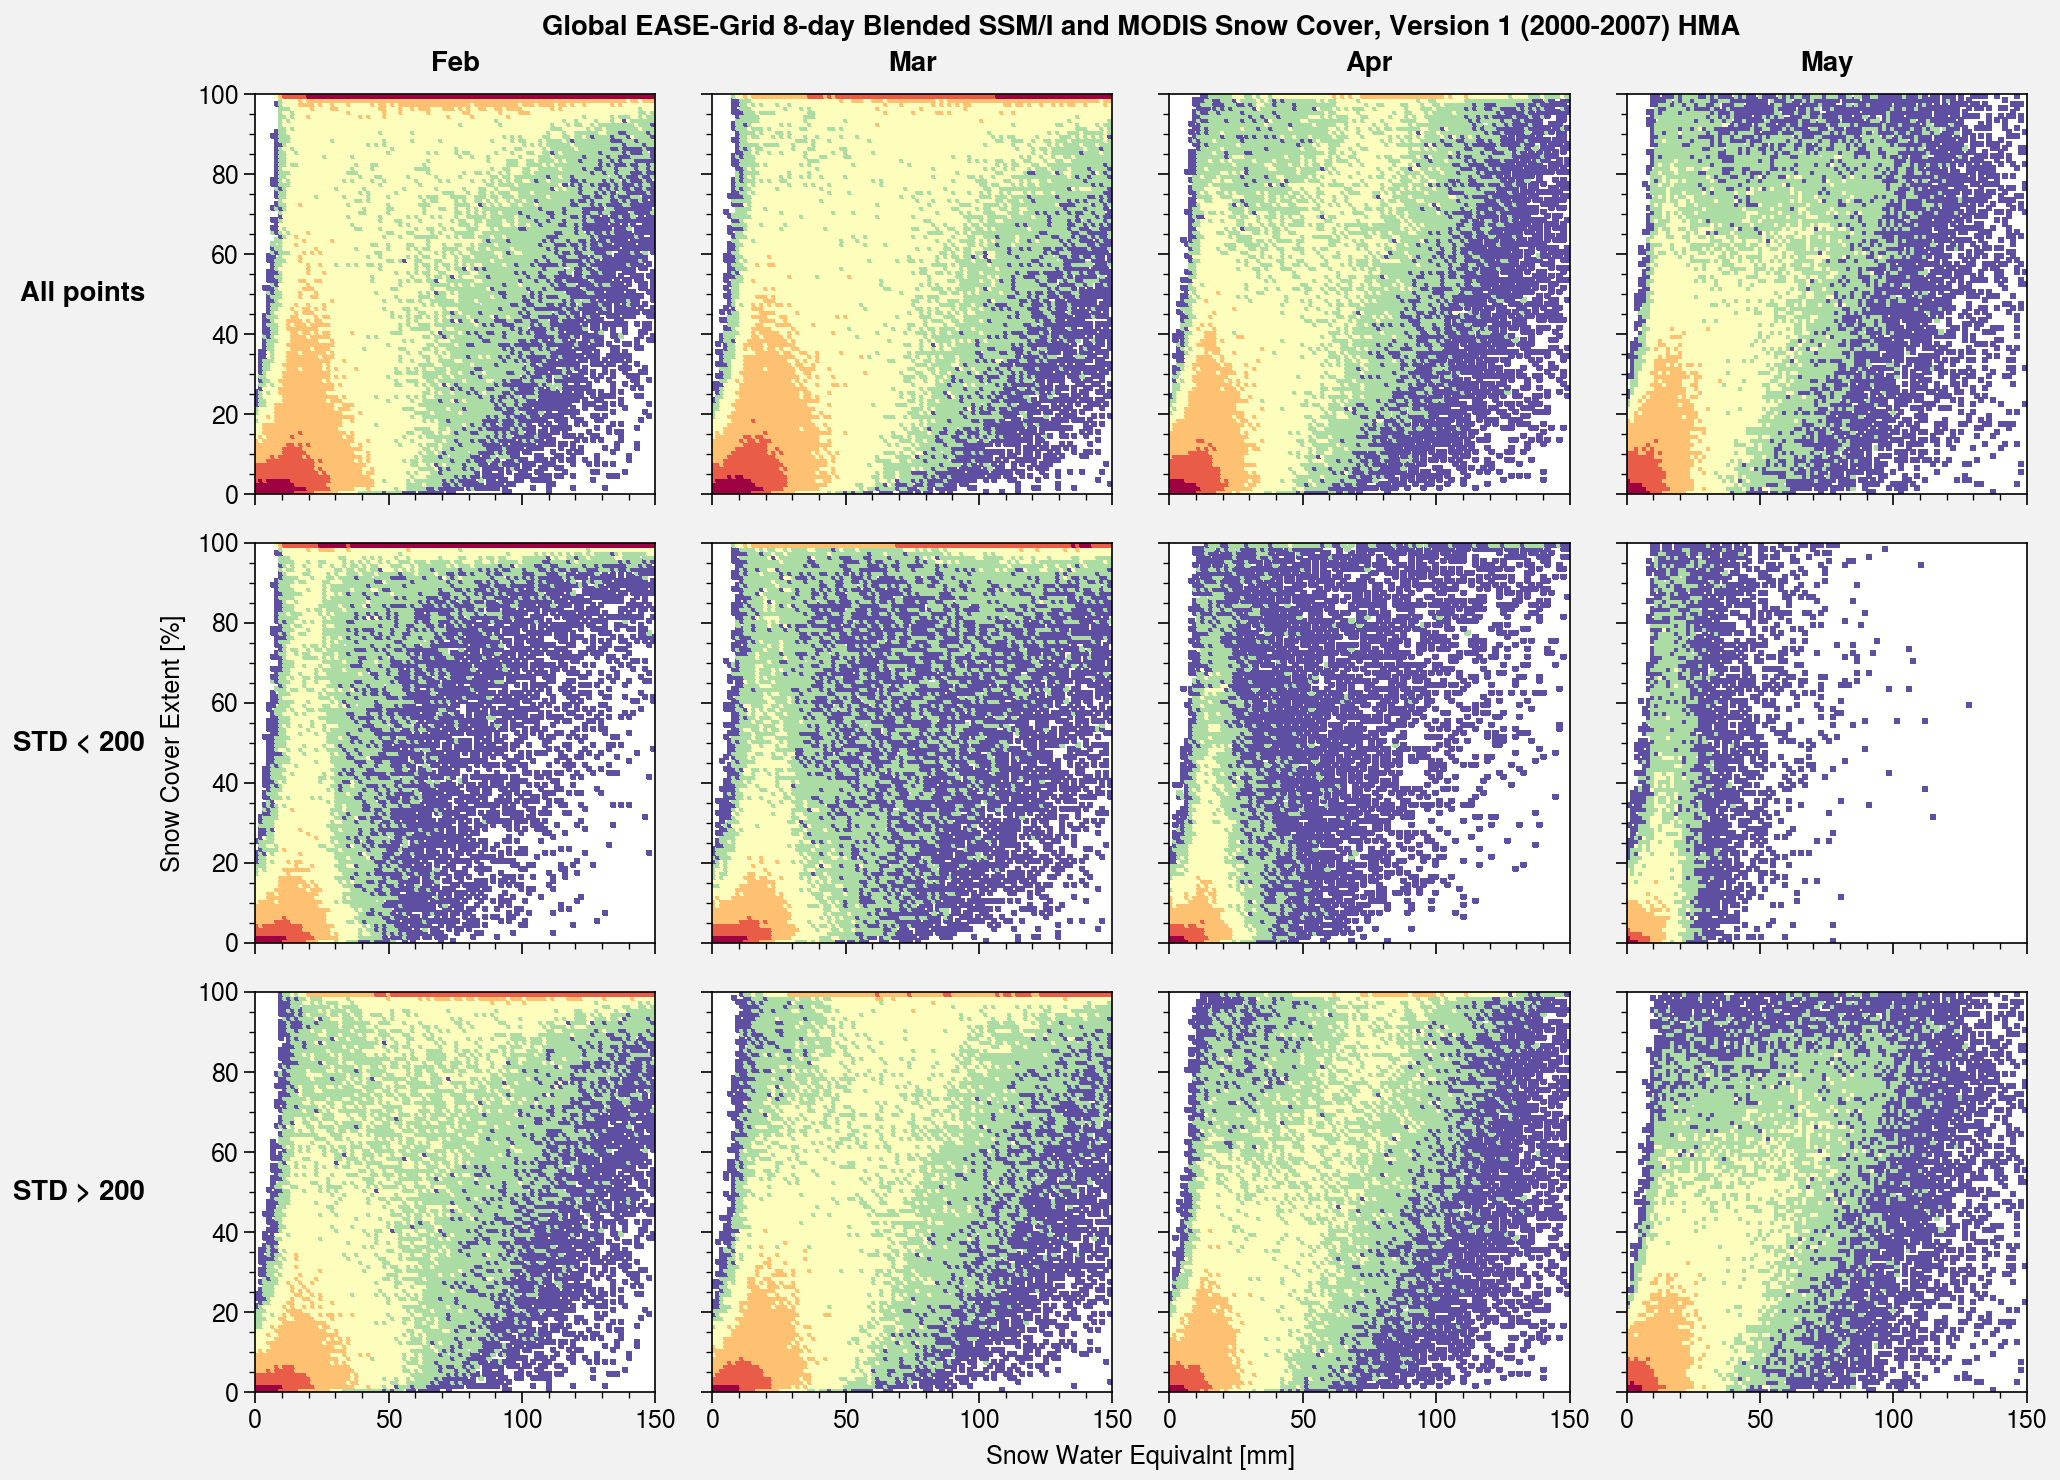

In [149]:
fig, axs = plot.subplots(nrows=3, ncols=4, axwidth=2)

xylim = [[0, 150], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1


k = 0
# All points
for month in range(2,6):
    m = axs[k].hist2d(
        swe_regrid_HMA.where(swe_regrid_HMA['time.month'] == month, drop=True).where(
            swe_regrid_HMA > 0).values.flatten(), 
        scf_regrid_HMA.where(scf_regrid_HMA['time.month'] == month, drop=True).where(
            scf_regrid_HMA > 0).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD < 200
for month in range(2,6):
    m = axs[k].hist2d(
        swe_regrid_HMA.where(
            (swe_regrid_HMA['time.month'] == month) & (std_HMA < 200),
             drop=True
        ).where(swe_regrid_HMA > 0).values.flatten(), 
        scf_regrid_HMA.where(
            (scf_regrid_HMA['time.month'] == month) & (std_HMA < 200), 
            drop=True
        ).where(scf_regrid_HMA > 0).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD > 200
for month in range(2,6):
    m = axs[k].hist2d(
        swe_regrid_HMA.where(
            (swe_regrid_HMA['time.month'] == month) & (std_HMA > 200),
             drop=True
        ).where(swe_regrid_HMA > 0).values.flatten(), 
        scf_regrid_HMA.where(
            (scf_regrid_HMA['time.month'] == month) & (std_HMA > 200), 
            drop=True
        ).where(scf_regrid_HMA > 0).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

axs.format(
    collabels=['Feb', 'Mar', 'Apr', 'May'],
    rowlabels=['All points', 'STD < 200', 'STD > 200'],
    xlabel='Snow Water Equivalnt [mm]',
    ylabel='Snow Cover Extent [%]',
    suptitle='Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1 (2000-2007) HMA'
)

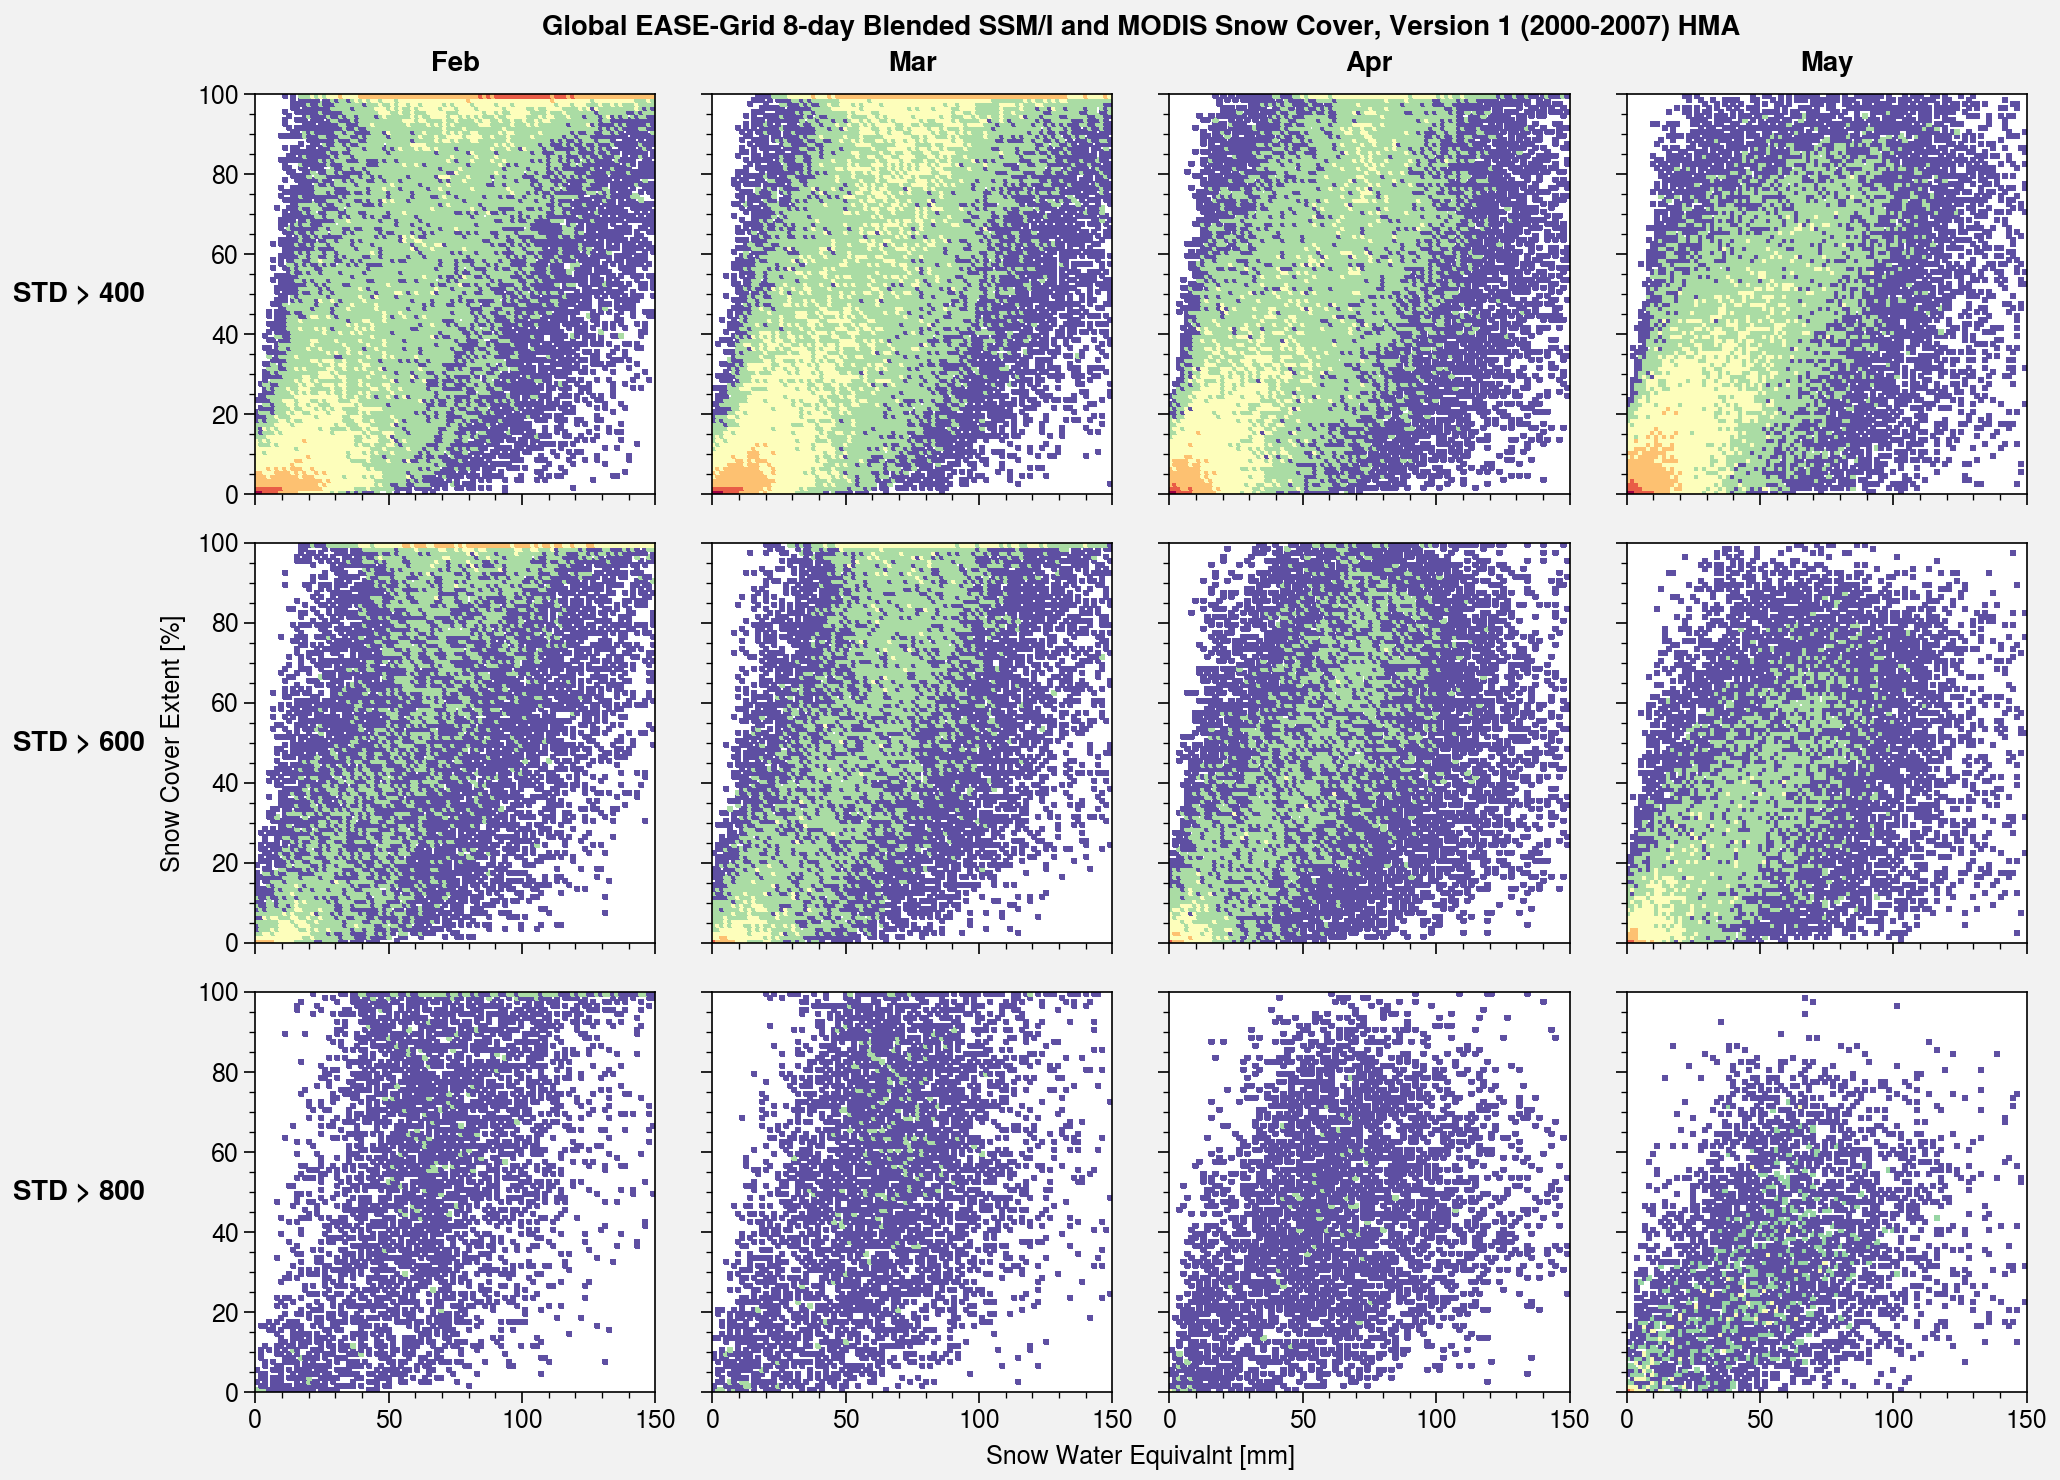

In [151]:
fig, axs = plot.subplots(nrows=3, ncols=4, axwidth=2)

xylim = [[0, 150], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1


k = 0

# STD > 400, 600, 800
for s in [400, 600, 800]:
    for month in range(2,6):
        m = axs[k].hist2d(
            swe_regrid_HMA.where(
                (swe_regrid_HMA['time.month'] == month) & (std_HMA > s),
                 drop=True
            ).where(swe_regrid_HMA > 0).values.flatten(), 
            scf_regrid_HMA.where(
                (scf_regrid_HMA['time.month'] == month) & (std_HMA > s), 
                drop=True
            ).where(scf_regrid_HMA > 0).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1

axs.format(
    collabels=['Feb', 'Mar', 'Apr', 'May'],
    rowlabels=['STD > 400', 'STD > 600', 'STD > 800'],
    xlabel='Snow Water Equivalnt [mm]',
    ylabel='Snow Cover Extent [%]',
    suptitle='Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1 (2000-2007) HMA'
)

### NH

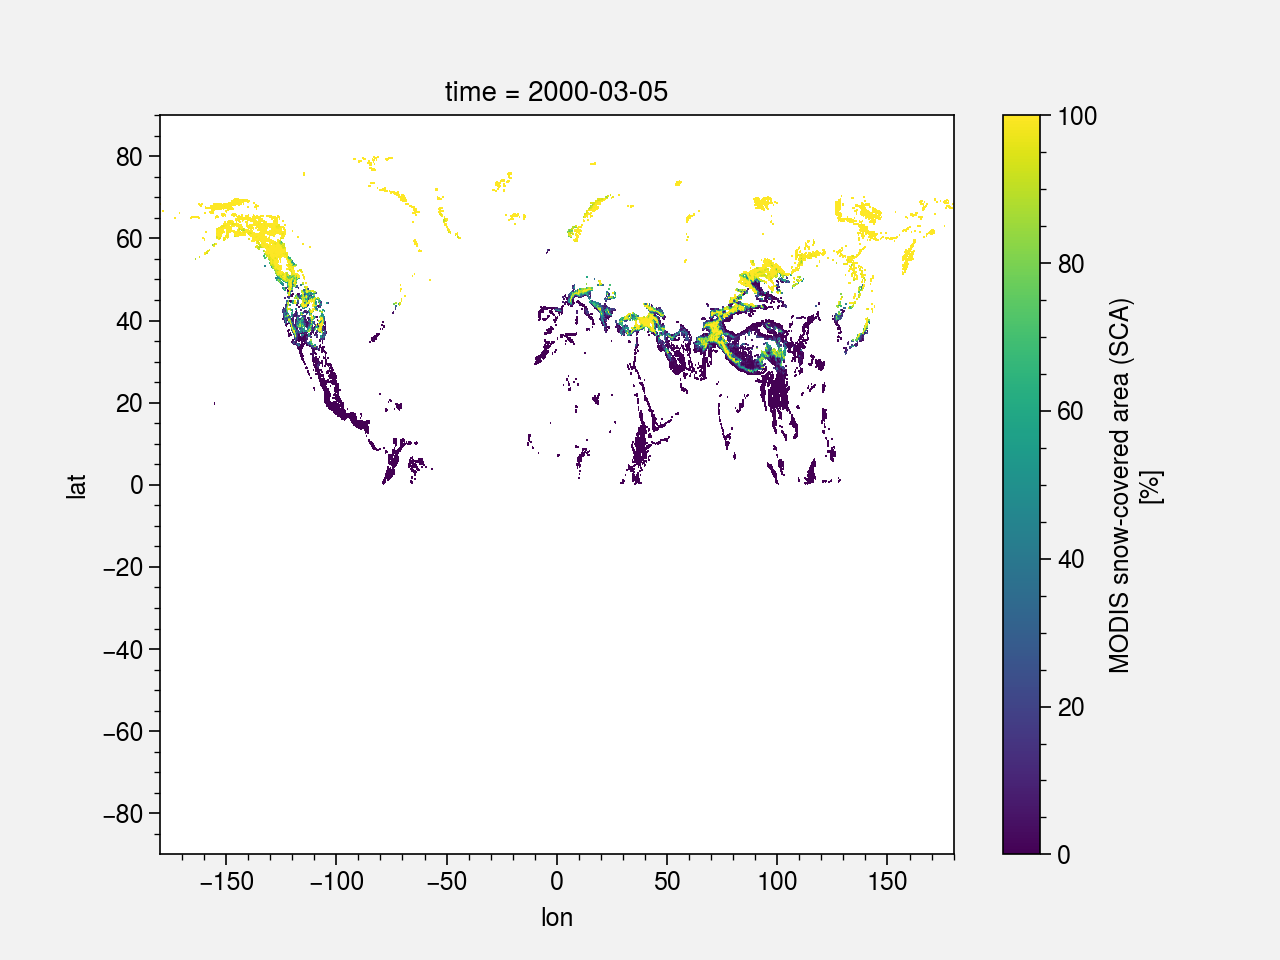

In [142]:
scf_regrid.where(std > 200)[0].plot()

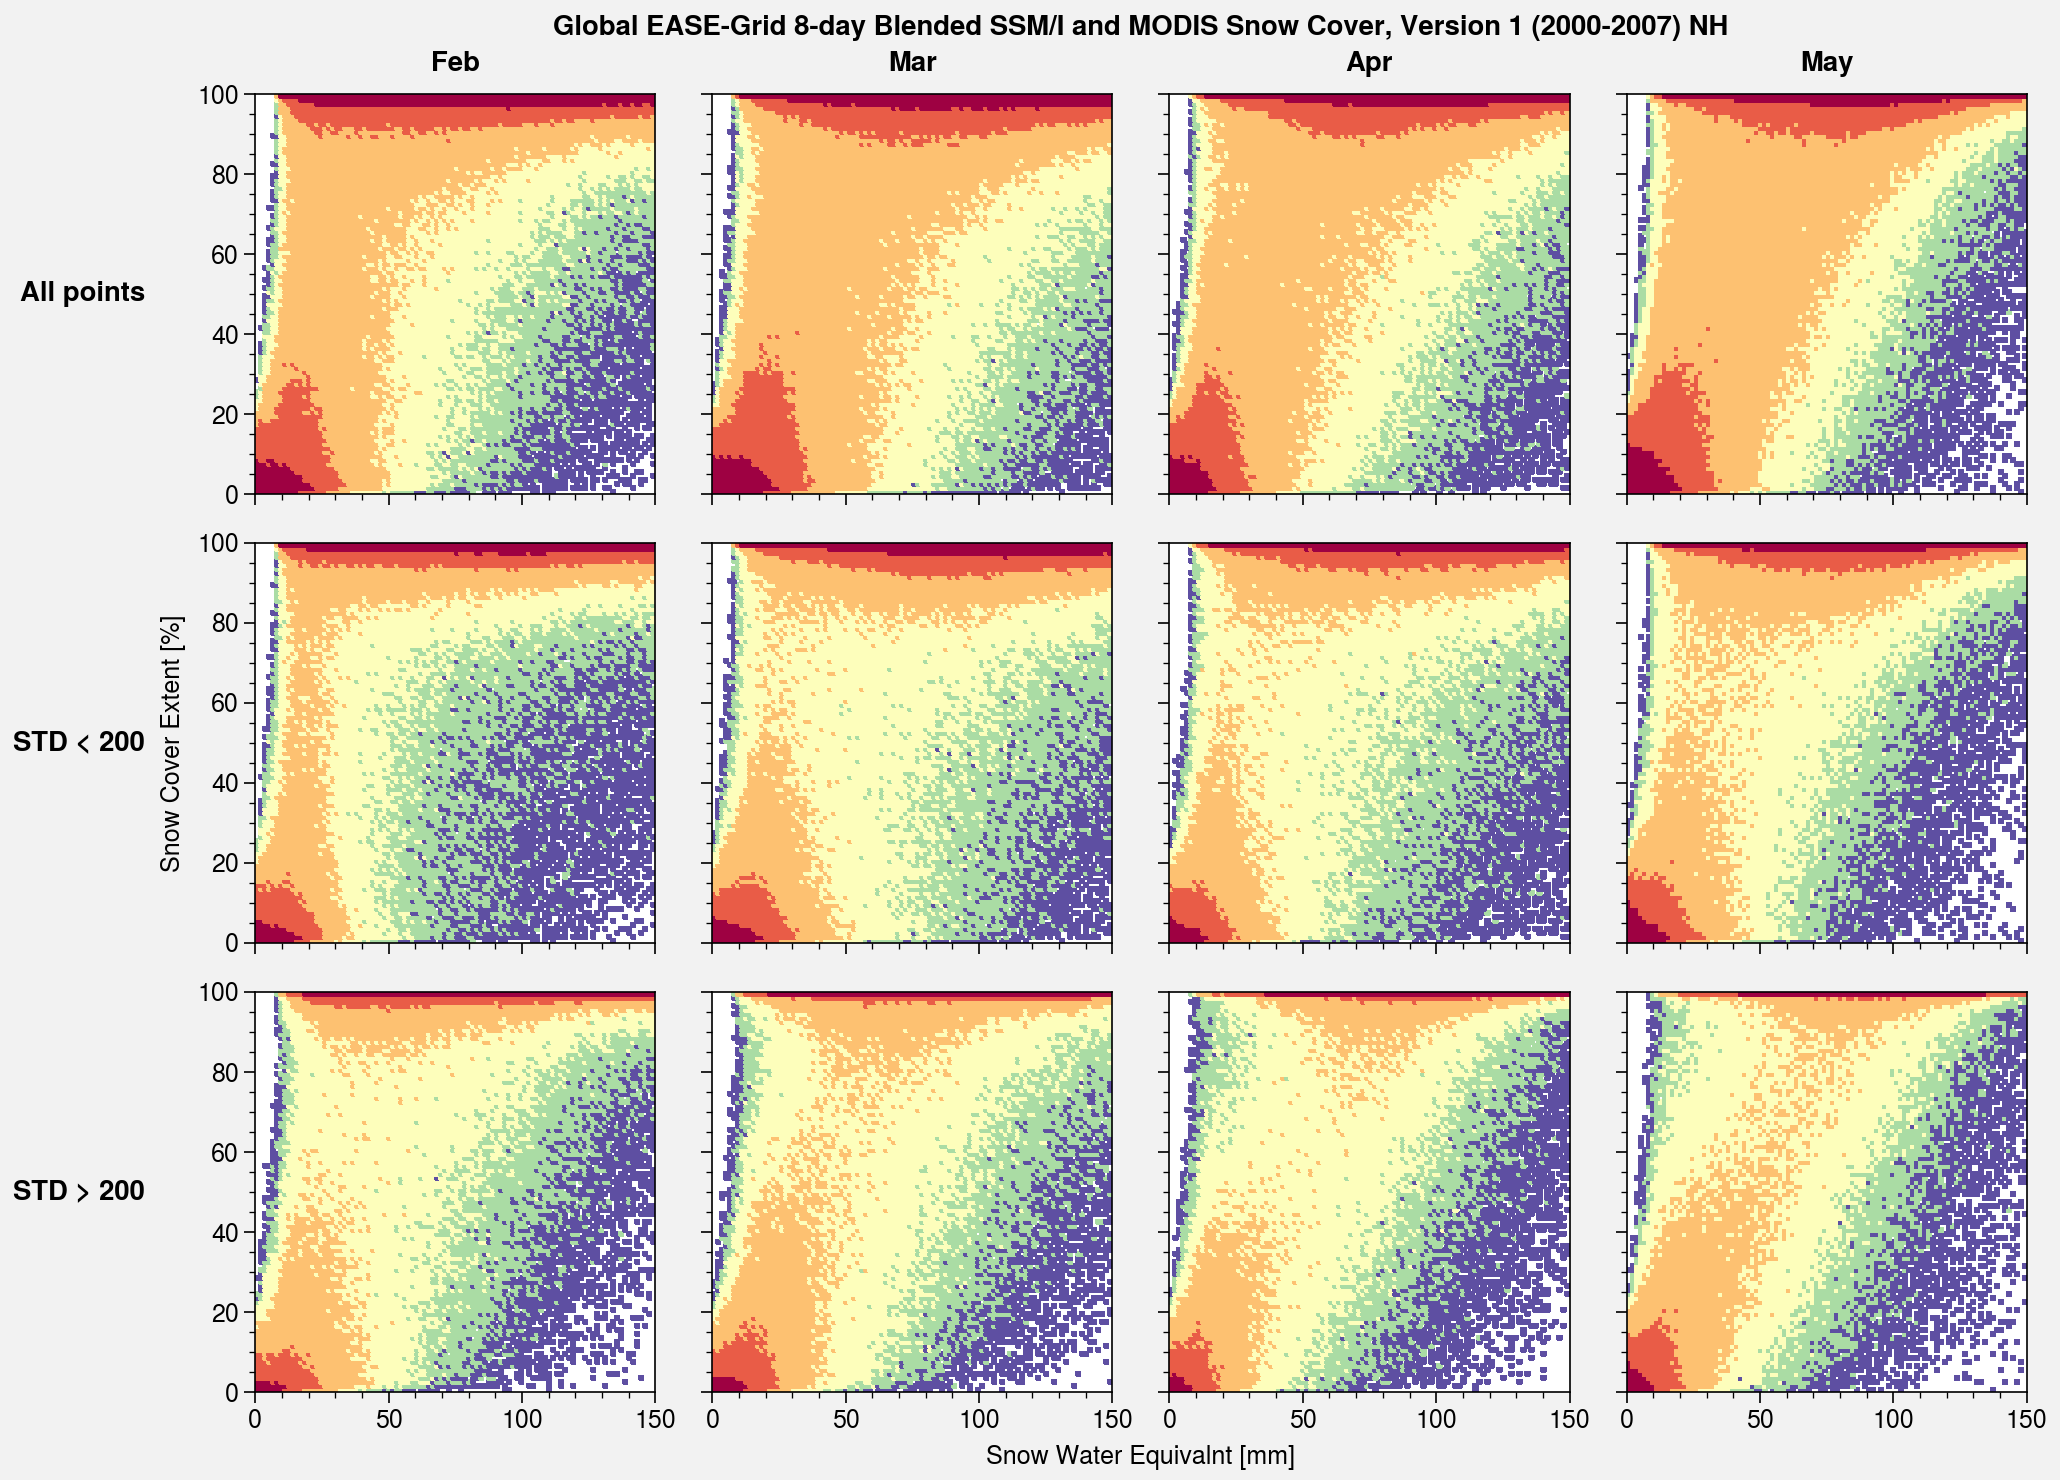

In [152]:
fig, axs = plot.subplots(nrows=3, ncols=4, axwidth=2)

xylim = [[0, 150], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1


k = 0
# All points
for month in range(2,6):
    m = axs[k].hist2d(
        swe_regrid.where(swe_regrid['time.month'] == month, drop=True).where(
            swe_regrid > 0).values.flatten(), 
        scf_regrid.where(scf_regrid['time.month'] == month, drop=True).where(
            scf_regrid > 0).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD < 200
for month in range(2,6):
    m = axs[k].hist2d(
        swe_regrid.where(
            (swe_regrid['time.month'] == month) & (std < 200),
             drop=True
        ).where(swe_regrid > 0).values.flatten(), 
        scf_regrid.where(
            (scf_regrid['time.month'] == month) & (std < 200), 
            drop=True
        ).where(scf_regrid > 0).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

# STD > 200
for month in range(2,6):
    m = axs[k].hist2d(
        swe_regrid.where(
            (swe_regrid['time.month'] == month) & (std > 200),
             drop=True
        ).where(swe_regrid > 0).values.flatten(), 
        scf_regrid.where(
            (scf_regrid['time.month'] == month) & (std > 200), 
            drop=True
        ).where(scf_regrid > 0).values.flatten(), 
        bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
    )
    k += 1

axs.format(
    collabels=['Feb', 'Mar', 'Apr', 'May'],
    rowlabels=['All points', 'STD < 200', 'STD > 200'],
    xlabel='Snow Water Equivalnt [mm]',
    ylabel='Snow Cover Extent [%]',
    suptitle='Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1 (2000-2007) NH'
)